<a href="https://colab.research.google.com/github/SJinLee/PPG/blob/main/03.LF_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -d input drive/MyDrive/ppg/archive.zip

Archive:  drive/MyDrive/ppg/archive.zip
  inflating: input/gamer1-annotations.csv  
  inflating: input/gamer1-ppg-2000-01-01.csv  
  inflating: input/gamer1-ppg-2000-01-02.csv  
  inflating: input/gamer2-annotations.csv  
  inflating: input/gamer2-ppg-2000-01-01.csv  
  inflating: input/gamer2-ppg-2000-01-02.csv  
  inflating: input/gamer3-annotations.csv  
  inflating: input/gamer3-ppg-2000-01-01.csv  
  inflating: input/gamer3-ppg-2000-01-02.csv  
  inflating: input/gamer4-annotations.csv  
  inflating: input/gamer4-ppg-2000-01-01.csv  
  inflating: input/gamer4-ppg-2000-01-02.csv  
  inflating: input/gamer5-annotations.csv  
  inflating: input/gamer5-ppg-2000-01-01.csv  
  inflating: input/gamer5-ppg-2000-01-02.csv  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
gamerID = 'gamer5'

In [136]:
def get_annotations(gamerID):
    dateCols = ['Datetime']
    anots = pd.read_csv('./input/' + gamerID + '-annotations.csv', parse_dates=dateCols)
    anots.dataframeName = gamerID + '-annotations'

    sss = anots[anots.Event == "Stanford Sleepiness Self-Assessment (1-7)"].drop('Event', axis=1).copy()
    sss['SelfAssess'] = sss['Value'].map(lambda x: float(x))

    rt = anots[anots.Event == "Sleep-2-Peak Reaction Time (ms)"].drop('Event', axis=1).copy()
    rt['ReactTime'] = rt['Value'].map(lambda x: float(x))

    diary = anots[anots.Event == "Diary Entry (text)"].drop('Event', axis=1).copy()
    return sss,rt,diary

In [137]:
def get_ppg(gamerID):
    ppg = pd.read_csv('./input/' + gamerID + '-ppg-2000-01-01.csv', delimiter=',')
    nextdaypos = np.where(ppg['Time'].iloc[:-1].values>ppg['Time'].iloc[1:].values)[0]
    assert(len(nextdaypos)<=1)
    ppg.dataframeName = gamerID + '-ppg-2000-01-01.csv'
    if len(nextdaypos)==0:
        ppg['Time'] = ppg['Time'].apply(lambda x: '2000-01-01 '+x)
    else:
        ppg.loc[:nextdaypos[0],'Time'] = ppg.loc[:nextdaypos[0],'Time'].apply(lambda x: '2000-01-01 '+x)
        ppg.loc[nextdaypos[0]+1:,'Time'] = ppg.loc[nextdaypos[0]+1:,'Time'].apply(lambda x: '2000-01-02 '+x)
    ppg_next = pd.read_csv('./input/' + gamerID + '-ppg-2000-01-02.csv', delimiter=',')
    ppg_next.dataframeName = gamerID + '-ppg-2000-01-02.csv'
    ppg_next['Time'] = ppg_next['Time'].apply(lambda x: '2000-01-02 '+x)
    ppg = pd.concat([ppg,ppg_next],axis=0).reset_index(drop=True)
    return ppg

In [90]:
def get_lowpass(ppg):
    ppg2 = ppg.copy()
    d = 0.7
    a = d
    b = 1-d
    xi = ppg2['Red_Signal'].values[1:].astype(float).copy()
    v = ppg2['Red_Signal'].values.astype(float).copy()
    y = v[0]
    i = 1
    for x in xi:
        y += b*(x-y)
        v[i] = y
        i += 1
    ppg2['Red_Signal2'] = v
    ppg2['Time'] = pd.to_datetime(ppg2['Time'])
    return ppg2

In [93]:
def draw_ppg(ppg2,start,period):
    t = ppg2['Time'][start:start+period]
    x = ppg2['Red_Signal'][start:start+period]
    y = ppg2['Red_Signal2'][start:start+period]
    plt.plot(t,x,label='input')
    plt.plot(t,y,label='output')
    plt.legend()

In [94]:
def get_peaks(ppg2,return_index=False):
    idx = ppg2['Red_Signal2'].iloc[:-2].values < ppg2['Red_Signal2'].iloc[1:-1].values
    idx &= ppg2['Red_Signal2'].iloc[2:].values < ppg2['Red_Signal2'].iloc[1:-1].values
    idx &= ppg2['Red_Signal2'].iloc[1:-1].values > 650
    idx = np.where(idx)[0]
    if return_index:
        return ppg2.loc[idx+1],idx+1
    return ppg2.loc[idx+1]

In [95]:
def get_peak_to_peak_distance(peaks):
    return peaks['Time'].diff() / pd.to_timedelta(1, unit='S')

In [171]:
def get_ppg_segment(ppg2,peaks,start='2000-01-01 13:00:00',duration=300):
    start = pd.to_datetime(start)
    end = start + pd.to_timedelta(duration, unit='S')
    before = ppg2.loc[ppg2['Time'] < start]
    start_idx = ppg2.index[0] if len(before)==0 else before.index[-1]
    after = ppg2.loc[ppg2['Time'] > end]
    end_idx = ppg2.index[-1] if len(after)==0 else after.index[0]
    ppg_seg = ppg2.loc[start_idx:end_idx]
    peaks_seg = peaks.loc[(peaks.index>=ppg_seg.index[0])&(peaks.index<=ppg_seg.index[-1])]
    return ppg_seg,peaks_seg
def get_ppg_segment2(ppg2,peaks,start='2000-01-01 13:00:00',duration=300):
    start = pd.to_datetime(start)
    end = start + pd.to_timedelta(duration, unit='S')
    before = peaks.loc[peaks['Time'] < start]
    start_idx = ppg2.index[0] if len(before)==0 else before.index[-1]
    after = peaks.loc[peaks['Time'] > end]
    end_idx = ppg2.index[-1] if len(after)==0 else after.index[0]
    ppg_seg = ppg2.loc[start_idx:end_idx]
    peaks_seg = peaks.loc[(peaks.index>=ppg_seg.index[0])&(peaks.index<=ppg_seg.index[-1])]
    return ppg_seg,peaks_seg

In [172]:
from scipy import interpolate
def draw_peaks(ppg_seg,peaks_seg):
    ppg_seg.set_index('Time').plot()
    plt.plot(peaks_seg['Time'],peaks_seg['Red_Signal2'],'ro')
    ff = (peaks_seg['Time']-peaks_seg['Time'].iloc[0]) / pd.to_timedelta(1, unit='S')
    f_cubic = interpolate.interp1d(ff,
                               peaks_seg['Red_Signal2'], kind='cubic') # , quadratic
    xnew = np.arange(peaks_seg['Time'].iloc[0]-peaks_seg['Time'].iloc[0],
                 peaks_seg['Time'].iloc[-1]-peaks_seg['Time'].iloc[0],100)
    xnew = xnew / pd.to_timedelta(1, unit='S')
    y_new = f_cubic(xnew)
    xnew2 = np.arange(peaks_seg['Time'].iloc[0],
                 peaks_seg['Time'].iloc[-1],100)
    plt.plot(pd.to_datetime(xnew2),y_new,color='green')

In [219]:
def sampling(peaks_seg,start='2000-01-01 13:00:00',duration=300,fs=10):
    origin = peaks_seg['Time'].iloc[0]
    ff = (peaks_seg['Time']-origin) / pd.to_timedelta(1, unit='S')
    f_cubic = interpolate.interp1d(ff,peaks_seg['Red_Signal2'], kind='cubic')
    start = pd.to_datetime(start)
    end = start + pd.to_timedelta(duration, unit='S')
    x_new = np.arange((start-origin) / pd.to_timedelta(1, unit='S'),
                     (end-origin) / pd.to_timedelta(1, unit='S'),1/fs)
    y_new = f_cubic(x_new)
    x_new = origin + pd.to_timedelta(x_new, unit='S')
    return x_new,y_new

In [138]:
sss,rt,diary = get_annotations(gamerID)

In [139]:
ppg = get_ppg(gamerID)

In [140]:
ppg2 = get_lowpass(ppg)

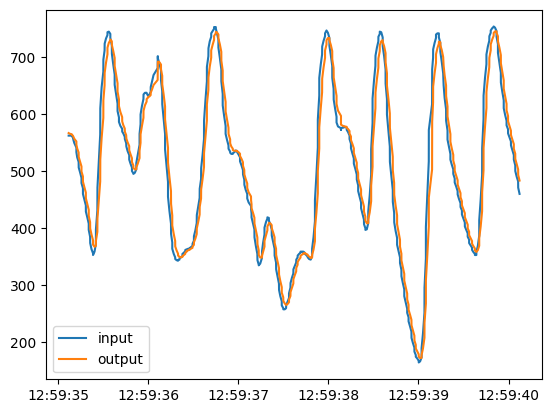

In [141]:
start,period=30000,500
draw_ppg(ppg2,start,period)

In [142]:
peaks,idx = get_peaks(ppg2,return_index=True)

In [143]:
ppg2.loc[idx[0]-1:idx[0]+1]

,Time,Red_Signal,Red_Signal2
166,2000-01-01 12:54:44.262265,689,675.672663
167,2000-01-01 12:54:44.262265,679,676.670864
168,2000-01-01 12:54:44.263262,665,673.169605


In [144]:
ppdists = get_peak_to_peak_distance(peaks)

In [145]:
ppdists.min(),ppdists.max()

(0.0, 3508.531518)

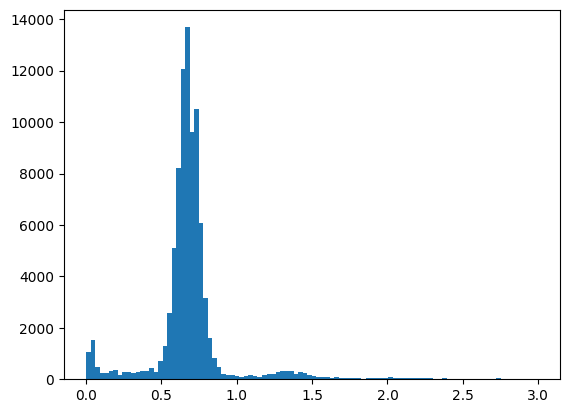

In [146]:
plt.hist(ppdists.loc[ppdists<3],bins=100)
plt.show()

In [167]:
ppg_seg,peaks_seg = get_ppg_segment(ppg2,peaks,start='2000-01-01 13:00:00.000000',duration=10)

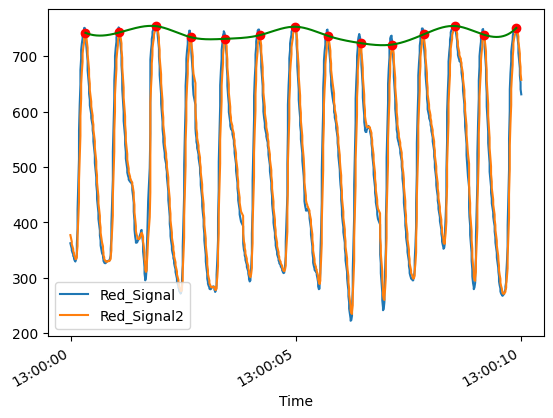

In [169]:
draw_peaks(ppg_seg,peaks_seg)

In [236]:
ppg_seg2,peaks_seg2 = get_ppg_segment2(ppg2,peaks,start='2000-01-01 13:00:00.000000',duration=120)

In [272]:
pptime,ppamp = sampling(peaks_seg2,start='2000-01-01 13:00:00',duration=120,fs=1)

(10957.541666666666, 10957.54304398148)

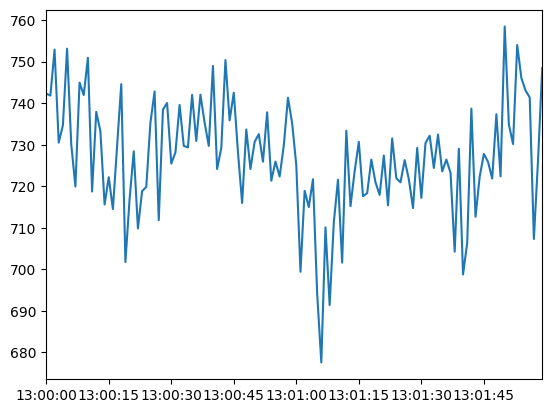

In [275]:
plt.plot(pptime,ppamp)
plt.xlim((pptime[0],pptime[119]))

# LF, HF가 fs에 따라 변동이 큼? - 오류 수정 필요

In [276]:
import scipy
f,v = scipy.signal.welch(ppamp, fs=1.0)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  warnings.warn('nperseg = {0:d} is greater than input length '


(0.0, 2.0)

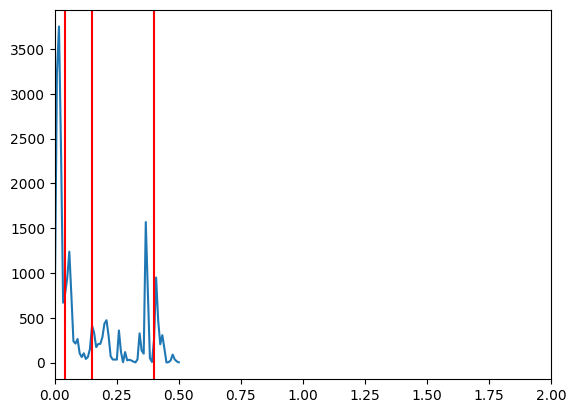

In [277]:
plt.plot(f,v)
plt.axvline(x=0.04,color='red')
plt.axvline(x=0.15,color='red')
plt.axvline(x=0.4,color='red')
plt.xlim((0.00,2.0))